**Import Library**

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

**Seismic Indicator Calculate Value Function**

In [6]:
def bvalue_OLS(magnitude_series):
    magnitudes = magnitude_series.value_counts().sort_index()
    
    M = magnitudes.index.tolist()
    values = magnitudes.tolist()
    N = np.cumsum(values[::-1])[::-1]
    logN = np.log10(N)
    b,a = np.polyfit(M, logN, 1)
    return b*(-1)

def mean_deviation_OLS(magnitude_series):
    magnitudes = magnitude_series.value_counts().sort_index()
    
    M = magnitudes.index.tolist()
    values = magnitudes.tolist()
    N = np.cumsum(values[::-1])[::-1]
    logN = np.log10(N)
    b,a = np.polyfit(M, logN, 1)
    b *= (-1)
    nu = 0
    for i in range (len(M)):
        nu += 1/(len(M)-1)*np.power(logN[i]-(a - (b * M[i])),2.0)
    return nu

def avalue_OLS(magnitude_series):
    magnitudes = magnitude_series.value_counts().sort_index()
    
    M = magnitudes.index.tolist()
    values = magnitudes.tolist()
    N = np.cumsum(values[::-1])[::-1]
    logN = np.log10(N)
    b,a = np.polyfit(M, logN, 1)
    return a

In [7]:
##Data gempa (Pandas Dataframe) yang berisi waktu, tempat, dan besaran peristiwa diumpankan ke fungsi sebagai input

#Ekstraksi fitur non-parametrik (fitur yang tidak bergantung pada distribusi karakteristik dan hukum Gutenberg-Richter)
#Parameters: data_gempa (pd.DataFrame dengan data gempa),
#time_window (jumlah peristiwa yang digunakan saat menghitung indikator)

def generate_nonparam_features(earthquake_dataset, time_window):
    
    earthquake_dataset['Elapsed time between last N events'] = (earthquake_dataset['time'].shift(1)-earthquake_dataset['time'].shift(time_window+1))
    earthquake_dataset['Elapsed days'] = earthquake_dataset['Elapsed time between last N events'].dt.days    
    earthquake_dataset['Mean magnitude'] = earthquake_dataset['mag'].rolling(time_window).mean().shift(1)
    earthquake_dataset['Square root of energy'] = np.sqrt(np.power(10.0, (11.8 + (1.5*earthquake_dataset['mag']))))
    earthquake_dataset['Rate of square root of energy released'] = earthquake_dataset['Square root of energy'].rolling(time_window).sum().shift(1)
    earthquake_dataset['Rate of square root of energy released'] = earthquake_dataset['Rate of square root of energy released']/earthquake_dataset['Elapsed days']    
    earthquake_dataset = earthquake_dataset.drop(columns = ["Elapsed time between last N events","Square root of energy"])
    return earthquake_dataset

#Ekstraksi fitur berdasarkan hukum Gutenberg-Richter (nilai-b diperoleh dengan metode kuadrat terkecil)
#Parameters: data_gempa (pd.DataFrame dengan data gempa),

def generate_GR_Adeli_Panakkat_features(earthquake_dataset, time_window):
    earthquake_dataset['b-value'] = earthquake_dataset['mag'].rolling(time_window).apply(func=bvalue_OLS,raw = False).shift(1)
    earthquake_dataset['Mean square deviation'] = earthquake_dataset['mag'].rolling(time_window).apply(func=mean_deviation_OLS,raw = False).shift(1)
    earthquake_dataset['a-value'] = earthquake_dataset['mag'].rolling(time_window).apply(func=avalue_OLS,raw = False).shift(1)
    earthquake_dataset['Max magnitude expected'] = earthquake_dataset['a-value']/earthquake_dataset['b-value']
    earthquake_dataset['Max magnitude observed'] = earthquake_dataset['mag'].rolling(time_window).max().shift(1)
    earthquake_dataset['Magnitude deficit'] = earthquake_dataset['Max magnitude observed'] - earthquake_dataset['Max magnitude expected']
    earthquake_dataset = earthquake_dataset.drop(columns = ["a-value","Max magnitude expected", "Max magnitude observed"])
    return earthquake_dataset

def generate_characteristic_features(earthquake_dataset, time_window, lower_bound, upper_bound):
    earthquake_dataset['Mean time between characteristic events'] = np.nan
    earthquake_dataset['Coefficient of variation from mean time'] = np.nan
    for i in range (time_window, len(earthquake_dataset)):
        char_events = earthquake_dataset.iloc[i-time_window:i].copy(deep=True)
        char_events = char_events[char_events['mag'] >= lower_bound]
        char_events = char_events[char_events['mag'] <= upper_bound].sort_values(by='time',ascending=True).reset_index(drop = True)
        char_events['Time between this event and the previous one'] = (char_events['time']-char_events['time'].shift(1)).dt.days
        char_std = char_events['Time between this event and the previous one'].std()
        mean_time_char = char_events['Time between this event and the previous one'].mean()
        earthquake_dataset['Mean time between characteristic events'].iloc[i] = mean_time_char 
        earthquake_dataset['Coefficient of variation from mean time'].iloc[i] = mean_time_char/char_std
        print(i/len(earthquake_dataset)*100,'%')
    return earthquake_dataset

Sebagai contoh, pertimbangkan perhitungan indikator seismik untuk sekumpulan kecil data gempa di Jepang Tengah (data diambil dari katalog USGS)

In [8]:
#from google.colab import drive
#drive.mount("/content/drive")

#jika dari dataset github
dataset = "https://raw.githubusercontent.com/arifadli/DatasetRepository/main/Kaggle/Adeli_Panakkat_Reyes/usgs_japan_1968_2018.csv"
japan_raw = pd.read_csv(dataset)
japan_raw.head()
#df = pd.read_csv(dataset)
#df.head(5)

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,1968-02-25T20:00:32.000Z,37.586,141.650,65.5,5.6,mw,NaN,NaN,NaN,NaN,...,2015-05-13T18:53:01.000Z,"near the east coast of Honshu, Japan",earthquake,NaN,NaN,NaN,NaN,automatic,iscgem,iscgem
1,1968-05-19T04:12:38.000Z,35.626,141.955,20.0,6.3,mw,NaN,NaN,NaN,NaN,...,2015-05-13T18:53:01.000Z,"near the east coast of Honshu, Japan",earthquake,NaN,NaN,NaN,NaN,automatic,iscgem,iscgem
2,1968-07-01T10:45:12.000Z,35.999,139.348,60.6,6.1,mw,NaN,NaN,NaN,NaN,...,2017-04-13T21:43:18.559Z,"near the south coast of Honshu, Japan",earthquake,NaN,NaN,NaN,NaN,automatic,iscgem,iscgem
3,1968-08-08T04:55:10.000Z,36.363,141.587,37.6,5.8,mw,NaN,NaN,NaN,NaN,...,2015-05-13T18:53:02.000Z,"near the east coast of Honshu, Japan",earthquake,NaN,NaN,NaN,NaN,automatic,iscgem,iscgem
4,1969-04-09T12:57:25.000Z,36.825,139.853,110.4,5.7,mw,NaN,NaN,NaN,NaN,...,2015-05-13T18:53:02.000Z,"eastern Honshu, Japan",earthquake,NaN,NaN,NaN,NaN,automatic,iscgem,iscgem


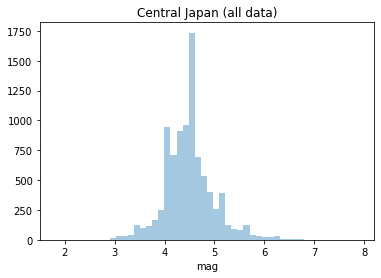

In [9]:
japan_raw['time'] = pd.to_datetime(japan_raw['time'], format='%Y-%m-%dT%H:%M:%S.%fZ')
jp = sns.distplot(japan_raw[japan_raw['mag']>0]['mag'], kde = False).set_title("Central Japan (all data)")

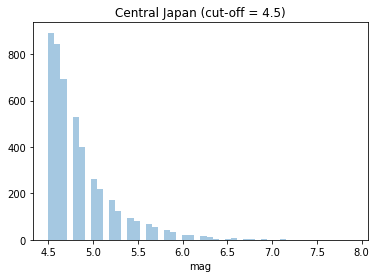

In [10]:
jp = sns.distplot(japan_raw[japan_raw['mag']>=4.5]['mag'], kde = False).set_title("Central Japan (cut-off = 4.5)")

In [11]:
japan_raw=japan_raw.drop(columns = ["id","nst","magType","gap","dmin","rms","net","updated",
                                    "place","type","horizontalError","depthError",
                                    "magError","magNst","status","locationSource","magSource"])
japan_raw.head()

,time,latitude,longitude,depth,mag
0,1968-02-25 20:00:32,37.586,141.650,65.5,5.6
1,1968-05-19 04:12:38,35.626,141.955,20.0,6.3
2,1968-07-01 10:45:12,35.999,139.348,60.6,6.1
3,1968-08-08 04:55:10,36.363,141.587,37.6,5.8
4,1969-04-09 12:57:25,36.825,139.853,110.4,5.7


In [12]:
japan_complete = japan_raw[japan_raw.mag >= 4.5].reset_index(drop = True)

In [13]:
japan_complete = generate_GR_Adeli_Panakkat_features(japan_complete, 50)
japan_complete = generate_nonparam_features(japan_complete, 50)
japan_complete = generate_characteristic_features(japan_complete, 50, 5.0, 5.5)

1.0860121633362294 %
1.107732406602954 %
1.1294526498696786 %
1.1511728931364031 %
1.1728931364031276 %
1.1946133796698521 %
1.2163336229365769 %
1.2380538662033016 %
1.259774109470026 %
1.2814943527367506 %
1.3032145960034751 %
1.3249348392701998 %
1.3466550825369243 %
1.368375325803649 %
1.3900955690703736 %
1.4118158123370983 %
1.4335360556038228 %
1.4552562988705473 %
1.4769765421372718 %
1.4986967854039965 %
1.520417028670721 %
1.5421372719374458 %
1.5638575152041705 %
1.585577758470895 %
1.6072980017376195 %
1.629018245004344 %
1.6507384882710685 %
1.6724587315377932 %
1.6941789748045177 %
1.7158992180712425 %
1.7376194613379672 %
1.7593397046046917 %
1.7810599478714162 %
1.8027801911381407 %
1.8245004344048652 %
1.84622067767159 %
1.8679409209383144 %
1.8896611642050392 %
1.9113814074717639 %
1.9331016507384884 %
1.954821894005213 %
1.9765421372719374 %
1.998262380538662 %
2.0199826238053866 %
2.041702867072111 %
2.0634231103388356 %
2.0851433536055604 %
2.106863596872285 %
2.12

In [14]:
japan_complete.tail()

,time,latitude,longitude,depth,mag,b-value,Mean square deviation,Magnitude deficit,Elapsed days,Mean magnitude,Rate of square root of energy released,Mean time between characteristic events,Coefficient of variation from mean time
4599,2018-12-24 05:42:38.460,34.1498,141.4503,10.00,4.6,1.277810,0.007787,-0.082027,137.0,4.748,1.248402e+09,27.0,1.125652
4600,2018-12-24 09:13:48.470,34.0378,141.6726,10.00,4.5,1.273985,0.007762,-0.082965,135.0,4.746,1.263771e+09,27.0,1.125652
4601,2018-12-24 23:20:02.810,34.0691,141.5657,10.00,4.7,1.270657,0.007663,-0.083995,135.0,4.744,1.261141e+09,27.0,1.125652
4602,2018-12-25 00:10:30.660,34.0316,141.6199,10.00,5.3,1.277810,0.007787,-0.082027,132.0,4.748,1.295690e+09,27.0,1.125652
4603,2018-12-31 14:10:25.440,37.4904,141.4337,44.89,5.1,1.278757,0.004951,-0.103251,132.0,4.762,1.335540e+09,21.6,0.898986


In [28]:
japan_grouped = japan_complete.set_index('time')
japan_grouped_parameters = japan_grouped[['b-value','Mean square deviation','Magnitude deficit','Elapsed days', 'Mean magnitude','Rate of square root of energy released','Mean time between characteristic events', 'Coefficient of variation from mean time']].resample('M').first()
japan_grouped_maxmag = japan_grouped['mag'].resample('M').m
japan_grouped = pd.merge(japan_grouped_parameters, japan_grouped_maxmag, how='outer', left_index=True, right_index=True)
japan_grouped.tail()

TypeError: ignored